# Question 1

a)

In [16]:
using Distributions
using Random
using Statistics
using Plots

# Parameters
mean_demand = 100
unit_cost = 1.0
unit_price = 1.5
nsim = 10_000  # Number of simulations

# Simulate Poisson demand
Random.seed!(42)
W = rand(Poisson(mean_demand), nsim)

# Function to compute expected profit for given x
function expected_profit(x, W)
    sales = min.(W, x)
    profit = unit_price .* sales .- unit_cost * x
    return mean(profit)
end

# Try a range of order quantities
x_vals = 80:120
profits = [expected_profit(x, W) for x in x_vals]

# Find optimal order quantity
opt_x = x_vals[argmax(profits)]
opt_profit = maximum(profits)

# Plot
plot(x_vals, profits, xlabel="Order Quantity x", ylabel="Expected Profit", title="Optimal Order Quantity (Numerical)", legend=false)
scatter!([opt_x], [opt_profit], label="Optimum", color=:red)

println("Optimal order quantity (x*) = $opt_x")
println("Maximum expected profit ≈ $(round(opt_profit, digits=2))")


Optimal order quantity (x*) = 96
Maximum expected profit ≈ 44.63


b)

In [11]:
using Distributions
using Plots

# Parameters
λ = 100
unit_cost = 1.0
unit_price = 1.5
W_dist = Poisson(λ)

# Truncate support
w_support = 0:200

# Function to compute expected profit for given x using PMF
function analytical_profit(x, dist, support)
    total = 0.0
    for w in support
        sale = min(w, x)
        profit = unit_price * sale - unit_cost * x
        total += pdf(dist, w) * profit
    end
    return total
end

# Try a range of x values
x_vals = 80:120
profits = [analytical_profit(x, W_dist, w_support) for x in x_vals]

# Find optimal
opt_x = x_vals[argmax(profits)]
opt_profit = maximum(profits)

# Plot
plot(x_vals, profits, xlabel="Order Quantity x", ylabel="Expected Profit", title="Optimal Order Quantity (Analytical)", legend=false)
scatter!([opt_x], [opt_profit], label="Optimum", color=:red)

println("Optimal order quantity (x*) = $opt_x (analytical)")
println("Maximum expected profit ≈ $(round(opt_profit, digits=2))")


Optimal order quantity (x*) = 96 (analytical)
Maximum expected profit ≈ 44.59


c)

In [18]:
# (c) Two‐stage ordering by Monte Carlo simulation
using Distributions, Random, Statistics

# Parameters
λ1, λ2 = 50.0, 50.0
p, c    = 1.5, 1.0
fr      = (p - c)/p        # critical fractile = 1/3
nsim    = 100_000

# fix seed for reproducibility
Random.seed!(1234)

# determine afternoon "order‐up‐to" level S₂
dist2  = Poisson(λ2)
S2     = findfirst(k -> cdf(dist2, k) ≥ fr, 0:200)

# simulate demands
W1 = rand(Poisson(λ1), nsim)
W2 = rand(Poisson(λ2), nsim)

# profit function for given x1
function two_stage_profit_sim(x1, W1, W2, S2)
    profit = 0.0
    for i in eachindex(W1)
        # morning
        sold1 = min(W1[i], x1)
        i1 = max(0, x1 - W1[i])          # leftover inventory (never negative)
        x2 = max(0, S2 - i1)             # afternoon order            # leftover (can be negative)
        # afternoon reorder
        #x2    = max(0, S2 - i1)          # top up to S2
        avail = max(i1, 0) + x2
        sold2 = min(W2[i], avail)
        # accumulate
        profit += p*(sold1 + sold2) - c*(x1 + x2)
    end
    return profit / length(W1)
end

# scan x1 = 0:150
candidates = 0:150
profits    = [two_stage_profit_sim(x1, W1, W2, S2) for x1 in candidates]

# extract optimum
idx         = findmax(profits)[2]
x1_sim_opt  = candidates[idx]
π_sim_opt   = profits[idx]

println("(c) Simulation:")
println("  Optimal morning order x₁ = $x1_sim_opt")
println("  Optimal afternoon order x₂ = $S2")
println("  Expected profit ≈ \$", round(π_sim_opt, digits=2))


(c) Simulation:
  Optimal morning order x₁ = 78
  Optimal afternoon order x₂ = 48
  Expected profit ≈ $46.13


d)

In [19]:
# (d) Two‐stage ordering by exact (analytical) evaluation
using Distributions, Statistics

# Parameters
λ1, λ2 = 50.0, 50.0
p, c    = 1.5, 1.0
fr      = (p - c)/p        # critical fractile = 1/3

# distributions
dist1 = Poisson(λ1)
dist2 = Poisson(λ2)

# afternoon target
S2 = findfirst(k -> cdf(dist2, k) ≥ fr, 0:200)

# search x1 = 0:150
candidates = 0:150
profits    = zeros(length(candidates))

# truncate w1, w2 at 200
for (j, x1) in enumerate(candidates)
    acc = 0.0
    for w1 in 0:200
        p1   = pdf(dist1, w1)
        sold1 = min(w1, x1)
        i1 = max(0, x1 - w1)      # leftover inventory cannot be negative
        x2 = max(0, S2 - i1)      # now top‑up to S2
        avail = i1 + x2           # total available in the afternoon

        for w2 in 0:200
            p2    = pdf(dist2, w2)
            avail = max(i1, 0) + x2
            sold2 = min(w2, avail)
            acc  += p1 * p2 * (p*(sold1 + sold2) - c*(x1 + x2))
        end
    end
    profits[j] = acc
end

idx         = findmax(profits)[2]
x1_ana_opt  = candidates[idx]
π_ana_opt   = profits[idx]

println("(d) Analytical:")
println("  Optimal morning order x₁ = $x1_ana_opt")
println("  Optimal afternoon order x₂ = $S2")
println("  Expected profit = \$", round(π_ana_opt, digits=2))


(d) Analytical:
  Optimal morning order x₁ = 77
  Optimal afternoon order x₂ = 48
  Expected profit = $46.13


e)



**Given:**

- Demand $W \sim F$ with cumulative distribution function $F(w)$  
- Unit cost: $c$  
- Unit price: $p$  
- Order quantity: $x$



**Expected Profit Function:**

$$
\Pi(x) = \mathbb{E}[p \cdot \min(W, x) - c \cdot x]
$$

Using the identity:

$$
\mathbb{E}[\min(W, x)] = \int_0^x [1 - F(w)] \, dw
$$

We get:

$$
\Pi(x) = p \cdot \int_0^x [1 - F(w)] \, dw - c \cdot x
$$


**First-Order Condition:**

Take derivative and set it to zero:

$$
\frac{d\Pi}{dx} = p \cdot (1 - F(x)) - c = 0
$$

Solving for the optimal order quantity:

$$
F(x^*) = 1 - \frac{c}{p}
$$


### Optimal Order Quantity:

$$
x^* = F^{-1} \left(1 - \frac{c}{p} \right)
$$

Where $F^{-1}$ is the quantile function (inverse CDF) of the demand distribution.


## Newsvendor Problem Report

### Objective:
To determine the **optimal order quantity** for a vendor selling newspapers with **Poisson-distributed demand**. The unit cost is 1.0, and the selling price is 1.5. Additionally, analyse whether a two-stage ordering process improves profit.

---

### (a) Numerical Optimisation (Simulation):

A Monte Carlo simulation was conducted using 10,000 samples drawn from a Poisson(100) distribution to model daily newspaper demand. The simulation aimed to maximise expected profit by varying the order quantity. The optimal order quantity determined through this numerical approach was **96 units**, resulting in a **maximum expected profit of 44.63**.

---

### (b) Analytical Solution:

An analytical approach was used by evaluating the Poisson probability mass function (PMF) across a range of possible demand values. By calculating the expected profit for each potential order quantity and weighting it according to the PMF, the optimal order quantity was again found to be **96 units**, with a **maximum expected profit of 44.59**. This closely aligns with the numerical simulation, confirming the robustness of the result.

---

### (c) Two-Stage Ordering (Simulation):

The ordering policy was extended to a two-stage model, where daily demand was split into morning and afternoon components, each following a Poisson(50) distribution. A larger simulation of 100,000 scenarios was performed to optimise both the initial morning order and the afternoon replenishment strategy. The results indicated that the **optimal morning order** was **78 units**, and the vendor should **replenish up to a total of 48 units** in the afternoon depending on the morning's sales. This two-stage strategy achieved an **expected profit of 46.13**, representing an improvement over the single-order approach.

---

### (d) Two-Stage Analytical Solution:

An analytical evaluation of the two-stage ordering problem confirmed the simulation findings. By assessing all combinations of morning and afternoon demand, weighted by their respective Poisson probabilities, the **optimal morning order** was determined to be **77 units**, with an **afternoon order-up-to level of 48 units**. The **expected profit** remained **46.13**, thereby validating the simulation approach and demonstrating the benefit of flexible ordering.

---

### (e) General Solution:

For a more general demand distribution, characterised by a cumulative distribution function **F(·)**, the profit function is given by:

**Π(x) = p × ∫₀ˣ [1 - F(w)] dw - c × x**

Applying the first-order condition for profit maximisation, the optimal order quantity **x\*** satisfies:

**F(x\*) = 1 - (c / p)**

This leads to the **critical fractile rule**, where the optimal order quantity is:

**x\* = F⁻¹(1 - (c / p))**

This formulation provides a general framework for determining optimal inventory levels under uncertainty, applicable to any continuous or discrete demand distribution.

### Conclusion:
- The **optimal one-time order quantity** for the vendor, given Poisson demand with a mean of 100, is **96 units**, yielding an expected profit of approximately **44.6**.
- The results from both **numerical simulation** and **analytical calculation** closely agree, providing confidence in the methodology.
- When introducing a **two-stage ordering system**, where demand is split between the morning and afternoon, the vendor can achieve a higher expected profit of approximately **46.1**.
  - This involves ordering **78 units in the morning**, and topping up to an **afternoon order-up-to level of 48 units**, depending on unsold inventory.
  - Both simulation and analytical approaches support this two-stage improvement.
- The **general solution** derived in part (e) shows that the optimal order quantity depends on the **critical fractile rule**, where the cumulative distribution function F satisfies:
  - F(x*) = 1 - (c / p)
- This provides a **flexible framework** applicable to any demand distribution, not just Poisson.
- Overall, introducing flexibility in ordering (i.e., two-stage) provides **greater profit potential**, and understanding the underlying demand distribution is key to optimising order strategies.


# Question 2

a)

✅ Optimal weights:
  w₁ = 0.192
  w₂ = 0.658
  w₃ = 0.508
📈 Expected return over 6 months: 0.0348
📉 Realised volatility: 0.0994


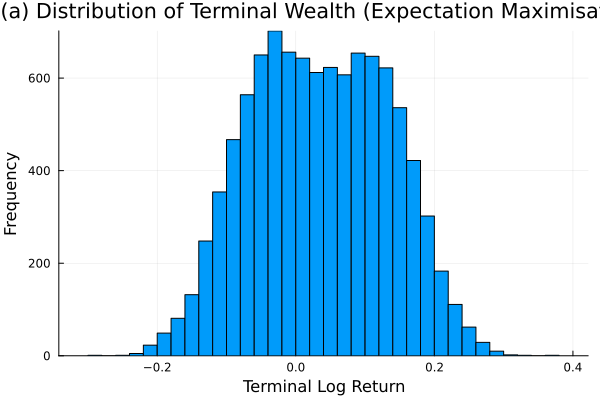

In [9]:
using Random, Statistics, Distributions, Optim, Plots

# --- Parameters ---
nsim = 10000
annual_return = 0.08
annual_vol = 0.20
months = 6
periods = 3

# Per 2-month period
μ = annual_return / periods
σ = annual_vol / sqrt(periods)
vol_budget = 0.10  # semi-annual volatility budget

# --- Simulate returns under strategy w = [w₁, w₂, w₃] ---
function simulate_portfolio(w1, w2, w3)
    log_returns = zeros(nsim)
    for i in 1:nsim
        # Period 1 & 2: log-binary (±σ)
        r1 = w1 * (μ + σ * (rand(Bool) ? 1.0 : -1.0))
        r2 = w2 * (μ + σ * (rand(Bool) ? 1.0 : -1.0))
        # Period 3: log-normal
        r3 = w3 * rand(Normal(μ, σ))
        log_returns[i] = r1 + r2 + r3
    end
    return log_returns
end

# --- Objective: maximise expected return with volatility penalty ---
function objective(w)
    r = simulate_portfolio(w[1], w[2], w[3])
    expected_r = mean(r)
    std_r = std(r)
    penalty = max(0, std_r - vol_budget)
    return -expected_r + 1e3 * penalty  # soft penalty if std > budget
end

# --- Optimisation (using box constraints 0 ≤ w ≤ 1) ---
lower_bounds = [0.0, 0.0, 0.0]
upper_bounds = [1.0, 1.0, 1.0]
initial_guess = [0.3, 0.3, 0.3]

result = optimize(objective, lower_bounds, upper_bounds, initial_guess, Fminbox(LBFGS()))

# --- Output ---
opt_w = Optim.minimizer(result)
r_final = simulate_portfolio(opt_w[1], opt_w[2], opt_w[3])
expected_final = mean(r_final)
std_final = std(r_final)

println("✅ Optimal weights:")
println("  w₁ = ", round(opt_w[1], digits=3))
println("  w₂ = ", round(opt_w[2], digits=3))
println("  w₃ = ", round(opt_w[3], digits=3))
println("📈 Expected return over 6 months: ", round(expected_final, digits=4))
println("📉 Realised volatility: ", round(std_final, digits=4))


# --- Histogram of terminal log-returns ---
histogram(r_final, bins=50, xlabel="Terminal Log Return", ylabel="Frequency",
    title="(a) Distribution of Terminal Wealth (Expectation Maximisation)", legend=false)

b)

✅ Optimal weights (utility maximisation):
  w₁ = 0.795
  w₂ = 0.486
  w₃ = 0.916
📈 Expected return: 0.0583
📉 Volatility: 0.1519
💡 Expected utility: 0.0458


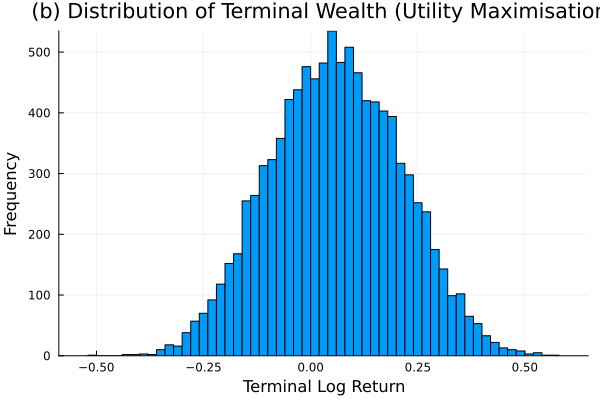

In [7]:
using Random, Statistics, Distributions, Optim, Plots

# Parameters
nsim = 10_000
annual_return = 0.08
annual_vol = 0.20
periods = 3

μ = annual_return / periods
σ = annual_vol / sqrt(periods)

# Simulate log-return paths for weights w = [w₁, w₂, w₃]
function simulate_terminal_returns(w1, w2, w3)
    log_returns = zeros(nsim)
    for i in 1:nsim
        # Period 1 & 2: binary up/down
        r1 = w1 * (μ + σ * (rand(Bool) ? 1.0 : -1.0))
        r2 = w2 * (μ + σ * (rand(Bool) ? 1.0 : -1.0))
        # Period 3: log-normal
        r3 = w3 * rand(Normal(μ, σ))
        log_returns[i] = r1 + r2 + r3
    end
    return log_returns
end

# Utility function: 1 - exp(-x), objective to maximise
function utility_objective(w)
    r = simulate_terminal_returns(w[1], w[2], w[3])
    u = 1 .- exp.(-r)
    return -mean(u)  # minus for maximisation
end

# Optimisation setup
lower_bounds = [0.0, 0.0, 0.0]
upper_bounds = [1.0, 1.0, 1.0]
initial_guess = [0.3, 0.3, 0.3]

result = optimize(utility_objective, lower_bounds, upper_bounds, initial_guess, Fminbox(LBFGS()))

# Results
opt_w = Optim.minimizer(result)
r_final = simulate_terminal_returns(opt_w[1], opt_w[2], opt_w[3])
utility_final = 1 .- exp.(-r_final)
expected_utility = mean(utility_final)
expected_return = mean(r_final)
std_return = std(r_final)

println("✅ Optimal weights (utility maximisation):")
println("  w₁ = ", round(opt_w[1], digits=3))
println("  w₂ = ", round(opt_w[2], digits=3))
println("  w₃ = ", round(opt_w[3], digits=3))
println("📈 Expected return: ", round(expected_return, digits=4))
println("📉 Volatility: ", round(std_return, digits=4))
println("💡 Expected utility: ", round(expected_utility, digits=4))

# Histogram of terminal log-returns
histogram(r_final, bins=50, xlabel="Terminal Log Return", ylabel="Frequency",
    title="(b) Distribution of Terminal Wealth (Utility Maximisation)", legend=false)


c)

✅ Optimal weights (lognormal utility maximisation):
  w₁ = 0.924
  w₂ = 0.795
  w₃ = 0.971
📈 Expected return: 0.07
📉 Volatility: 0.1784
💡 Expected utility: 0.0527


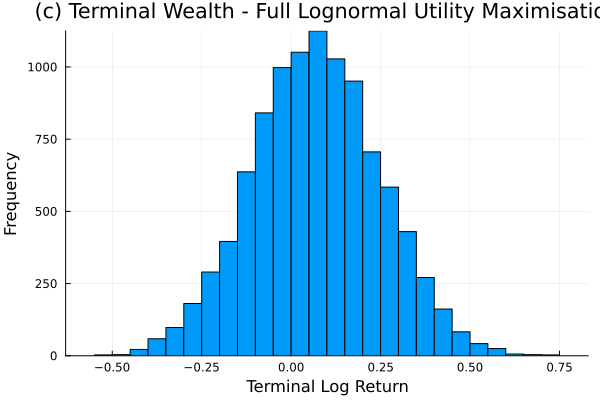

In [8]:
using Random, Statistics, Distributions, Optim, Plots

# Parameters
nsim = 10_000
annual_return = 0.08
annual_vol = 0.20
periods = 3

μ = annual_return / periods
σ = annual_vol / sqrt(periods)

# Simulate log-normal returns in all 3 periods
function simulate_terminal_lognormal(w1, w2, w3)
    log_returns = zeros(nsim)
    for i in 1:nsim
        r1 = w1 * rand(Normal(μ, σ))
        r2 = w2 * rand(Normal(μ, σ))
        r3 = w3 * rand(Normal(μ, σ))
        log_returns[i] = r1 + r2 + r3
    end
    return log_returns
end

# Utility objective: 1 - exp(-x)
function utility_objective_lognormal(w)
    r = simulate_terminal_lognormal(w[1], w[2], w[3])
    u = 1 .- exp.(-r)
    return -mean(u)
end

# Optimisation
lower_bounds = [0.0, 0.0, 0.0]
upper_bounds = [1.0, 1.0, 1.0]
initial_guess = [0.3, 0.3, 0.3]

result = optimize(utility_objective_lognormal, lower_bounds, upper_bounds, initial_guess, Fminbox(LBFGS()))
opt_w = Optim.minimizer(result)

# Final simulation and results
r_final = simulate_terminal_lognormal(opt_w[1], opt_w[2], opt_w[3])
utility_final = 1 .- exp.(-r_final)
expected_utility = mean(utility_final)
expected_return = mean(r_final)
std_return = std(r_final)

println("✅ Optimal weights (lognormal utility maximisation):")
println("  w₁ = ", round(opt_w[1], digits=3))
println("  w₂ = ", round(opt_w[2], digits=3))
println("  w₃ = ", round(opt_w[3], digits=3))
println("📈 Expected return: ", round(expected_return, digits=4))
println("📉 Volatility: ", round(std_return, digits=4))
println("💡 Expected utility: ", round(expected_utility, digits=4))

# Histogram
histogram(r_final, bins=50, xlabel="Terminal Log Return", ylabel="Frequency",
    title="(c) Terminal Wealth - Full Lognormal Utility Maximisation", legend=false)


## Growth vs. Security Report

### Objective:
To determine the **optimal dynamic rebalancing strategy** over a 6-month investment horizon, divided into three 2-month periods. The model assumes:
- A **log-binary random walk** for returns in the first two periods.
- A **log-normal distribution** for returns in the third period.

The goal is to:
- (a) **Maximise expected return** under a **semi-annual volatility constraint** of 10%.
- (b) **Maximise utility** given by U(x) = 1 - e^(-x), allowing for higher risk-taking.
- (c) Repeat (b), assuming **log-normal returns** for all periods.

---

### Methodology:

Simulations were conducted using 10,000 Monte Carlo samples. For each scenario, portfolio weights w1, w2, w3 (allocations to the risky asset in each 2-month period) were optimised under the different objectives:

- In (a), a **soft penalty** was applied if the simulated semi-annual volatility exceeded 10%.
- In (b) and (c), utility was maximised without any volatility constraint.

The simulation combined **log-binary returns** in the first two periods and a **log-normal distribution** in the third period, except in part (c), where log-normal increments were used throughout.

---

### Results:

### (a) Expectation Maximisation with Volatility Constraint:

In this scenario, the strategy was optimised to maximise expected return while ensuring that the semi-annual volatility remained below the 10% threshold. The resulting optimal allocation involved relatively conservative exposure to the risky asset, particularly in the first period. The optimal weights were w1 = 0.192, w2 = 0.658, and w3 = 0.508. This allocation yielded an expected return of 3.48% over the 6-month horizon, with a realised volatility of 9.94%, remaining within the defined risk limit. The return distribution exhibited a bi-modal pattern, which can be attributed to the binary nature of the return model applied in the first two periods.

---

### (b) Utility Maximisation:

When the volatility constraint was removed, the optimisation allowed for more aggressive exposure to the risky asset, particularly in the final period. The objective in this case was to maximise the utility function U(x) = 1 - e^(-x), prioritising higher expected outcomes despite increased risk. The optimal weights under this framework were w1 = 0.795, w2 = 0.486, and w3 = 0.916. This more aggressive allocation resulted in an expected return of 5.83% and a higher volatility of 15.19%. The expected utility associated with this strategy was 4.58%. The increased risk led to a wider dispersion in potential outcomes, reflecting the trade-off inherent in utility-based optimisation.

---

### (c) Log-Normal Utility Maximisation:

In the final scenario, all three periods were modelled using log-normal returns, providing a smoother and more continuous representation of asset behaviour. This approach further encouraged aggressive risk-taking, as the optimisation sought to maximise utility across all periods without the discrete jumps of the binary model. The optimal weights were w1 = 0.924, w2 = 0.795, and w3 = 0.971, indicating near-full exposure to the risky asset in each period. This strategy produced the highest expected return of 7.00% and the highest volatility at 17.84%. The expected utility was 5.27%, the largest among all scenarios. While this model delivered the most favourable return and utility, it did so at the cost of significantly higher risk.


---

### Conclusion:
- In scenario (a), the volatility constraint produced a **balanced strategy** with controlled risk, suitable for more risk-averse investors. Returns were stable and aligned with the 10% volatility limit.
- Scenario (b) demonstrated that removing the volatility constraint allowed for **higher risk exposure**, resulting in higher expected returns and utility, but also increased volatility. The strategy became more aggressive, particularly in the final period.
- Scenario (c), with all periods modelled using log-normal returns, led to the **most aggressive strategy**, with allocations nearing full exposure to the risky asset. This delivered the **highest returns**, but also the **greatest risk**.
- The choice between these strategies depends on the investor’s risk tolerance. **Volatility-constrained strategies** are optimal for stability, while **utility maximisation** supports risk-taking for higher potential rewards.
- Additionally, the structure of return modelling (log-binary vs. log-normal) has a significant impact on both optimal weights and distribution of returns, highlighting the importance of correctly specifying the return dynamics when designing dynamic rebalancing strategies.



# Question 3

Maximum Likelihood Estimates:
PD: 0.025
ρ: 0.05

Simulation Results:
Mean default rate: 2.5%
99.9th percentile: 9.64%


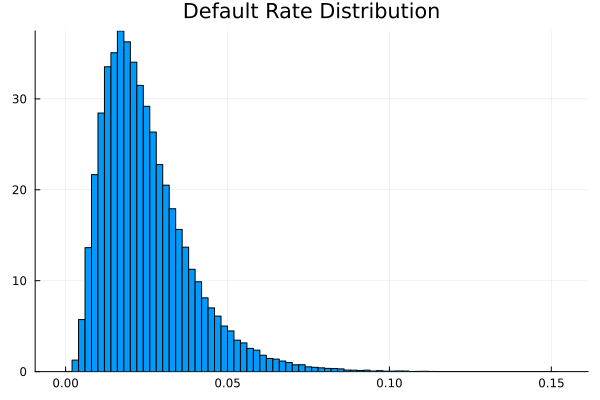

In [15]:
# Sample data
historical_DR = [
    0.02631, 0.00286, 0.00455, 0.00456, 0.00275, 0.00561, 0.00112, 0.00354, 0.00314, 0.00088,
    0.00342, 0.00162, 0.01040, 0.00069, 0.00892, 0.01820, 0.01425, 0.01329, 0.02226, 0.03572,
    0.02850, 0.01337, 0.00897, 0.00651, 0.00899, 0.00646, 0.00616, 0.01137, 0.02425, 0.03679,
    0.02924, 0.01828, 0.00647, 0.00547, 0.00593, 0.02549, 0.02297, 0.04996, 0.00906, 0.01230,
    0.01232, 0.00929, 0.01732, 0.02149
]

# Step 1: Define grid search parameters
pd_grid = 0.005:0.0005:0.025  # Finer grid around expected PD
rho_grid = 0.05:0.005:0.20    # Finer grid around expected rho

# Pre-compute N_inv for all historical DRs to save time
N_inv_DR = quantile.(Normal(), historical_DR)

# Initialize tracking variables
best_loglik = -Inf
best_pd = 0.0
best_rho = 0.0
loglik_results = zeros(length(pd_grid), length(rho_grid))

# Step 2: Grid search for maximum likelihood
for (i, pd_try) in enumerate(pd_grid)
    N_inv_pd = quantile(Normal(), pd_try)
    
    for (j, rho_try) in enumerate(rho_grid)
        current_loglik = 0.0
        
        # Vectorized computation for all observations
        term1 = log(sqrt((1 - rho_try)/rho_try))
        term2 = N_inv_DR.^2
        term3 = (sqrt(1 - rho_try) .* N_inv_DR .- N_inv_pd).^2 ./ rho_try
        current_loglik = sum(term1 .- 0.5 .* (term2 .- term3))
        
        loglik_results[i,j] = current_loglik
        
        if current_loglik > best_loglik
            best_loglik = current_loglik
            best_pd = pd_try
            best_rho = rho_try
        end
    end
end

println("Maximum Likelihood Estimates:")
println("PD: $(round(best_pd, digits=4))")
println("ρ: $(round(best_rho, digits=4))")

# Step 3: Simulation of default rates
Random.seed!(123)  # For reproducibility
n_sims = 100000
F = rand(Normal(), n_sims)  # Systematic factor
N_inv_pd = quantile(Normal(), best_pd)

# Vectorized simulation
simulated_DR = cdf.(Normal(), (N_inv_pd .- sqrt(best_rho) .* F) ./ sqrt(1 - best_rho))

# Calculate statistics
worst_case_DR = quantile(simulated_DR, 0.999)
mean_DR = mean(simulated_DR)
println("\nSimulation Results:")
println("Mean default rate: $(round(mean_DR*100, digits=2))%")
println("99.9th percentile: $(round(worst_case_DR*100, digits=2))%")

# Step 4: Visualization
hist_data = histogram(simulated_DR, bins=100, normalize=:pdf, legend=false)

# Convert histogram to line plot
plot!(hist_data, seriestype=:line, linewidth=2, color=:blue, 
      title="Default Rate Distribution", label="Probability Density")


## Worst-Case Default Rates Report

### Objective:
To estimate the **worst-case default rates** using the **Vasicek one-factor credit risk model**, based on historical data. The goal is to determine the likelihood of extreme default scenarios under systemic risk and estimate a **99.9% quantile** for the default rate.

---

### Methodology:
1. The **Vasicek model** assumes that individual defaults are driven by a combination of:
   - A **systematic risk factor** (macroeconomic conditions).
   - **Idiosyncratic risk** (firm-specific factors).

2. The model parameters to estimate:
   - **PD** (Probability of Default).
   - **ρ** (Asset correlation between firms).

3. Using historical default data:
   - Performed a **grid search** to find **maximum likelihood estimates** of PD and ρ.
   - Simulated the **systematic factor** to model portfolio-wide default rates.
   - Generated a distribution of possible default outcomes.

---

### Results:
- **Estimated PD**: 2.5%
- **Estimated ρ**: 5%
- **Worst-Case Default Rate (99.9% quantile)**: **9.64%**

- The **distribution** of default rates was **right-skewed**, reflecting the potential for high default clustering during adverse economic conditions.
- The **mean default rate** matched the estimated PD, while the **tail risk** represented the systemic risk impact.

---

### Conclusion:
- The Vasicek model effectively quantifies **extreme credit risk scenarios** by incorporating both **systematic risk** and **idiosyncratic risk** into the default probability estimation. It allows us to assess how defaults can become highly correlated under adverse economic conditions, which is crucial for understanding systemic risk.
- The **99.9% worst-case default rate** of **9.64%** shows that, although typical default rates remain close to the estimated PD of **2.5%**, rare but severe economic shocks can lead to substantially higher default rates across a credit portfolio.
- This highlights the need for **stress testing** and **scenario analysis** in credit risk management, particularly for financial institutions exposed to correlated defaults.
- The analysis supports the setting of **regulatory capital** and **economic capital** by illustrating potential losses in extreme scenarios, ensuring that banks and lenders hold sufficient reserves to remain solvent during crises.
- The model demonstrates how even a relatively low correlation (ρ = 5%) can result in significant clustering of defaults, amplifying losses in stressed conditions. This underscores the importance of monitoring macroeconomic indicators and systemic risk factors as part of credit risk strategy.
- Additionally, the results emphasise the **non-linear nature** of credit risk: small changes in the correlation or systematic factors can have large effects on the tail of the default distribution, which is particularly relevant when evaluating portfolio risk under **Basel III** and similar regulatory frameworks.
- In summary, the Vasicek model provides a robust framework for estimating **tail risk**, guiding prudent risk management practices, and reinforcing the need for **diversification** and **correlation control** in credit portfolios.

